#### Практическое задание
Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf


from sklearn.preprocessing import StandardScaler
import os
import datetime

In [2]:
%load_ext tensorboard

In [3]:
df = pd.read_csv('airline-passengers.csv')

In [4]:
df.head(3)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [5]:
df.shape

(144, 2)

In [6]:
df.index = df.Month
df.drop(['Month'],axis = 1,inplace = True)

In [7]:
df.sort_index(ascending=True, inplace=True)

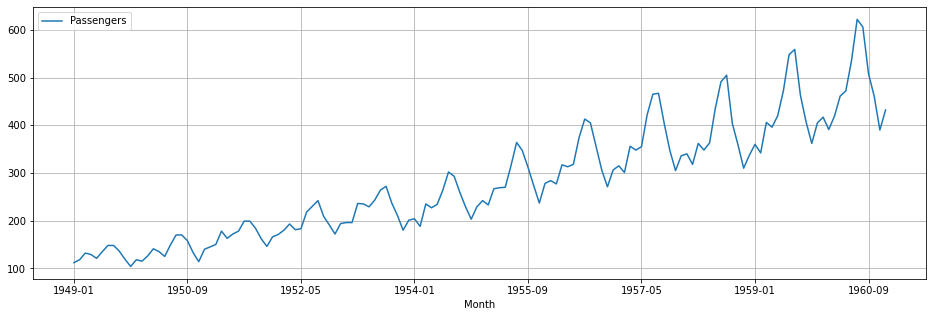

In [8]:
df.plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [9]:
df['day'] = pd.to_datetime(df.index).dayofyear/366.0
df['year'] = pd.to_datetime(df.index).year - 1949
df.head()


,Passengers,day,year
Month,,,
1949-01,112,0.002732,0
1949-02,118,0.087432,0
1949-03,132,0.163934,0
1949-04,129,0.248634,0
1949-05,121,0.330601,0


In [10]:
data = df.copy()

In [11]:
scaler = StandardScaler()

In [12]:
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [13]:
data.head(1)

,Passengers,day,year
Month,,,
1949-01,-1.407779,-1.586596,-1.593255


Разделим датасет по времени, Трейн предыдущие 70% времени, тест остальные 30%

In [14]:
train_split = 110 # Берем точку разделения датасета от начала
channelIndexes = [0,1,2]   # список признаков, по которым будем учить
# длина истории для работы
xLen = 7
# отступ тестов от тренировок
bias = 2

# вычисляем точку разделения ряда на тесты и тренировку

# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split+bias:,channelIndexes]

Параметры модели

In [15]:
# шаг по данным для построения обучающих примеров
step = 1
# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h = future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 1000

In [16]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values # X_valid - Все столбцы 
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее) 

In [17]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(103, 3)
(103,)
(25, 3)
(25,)


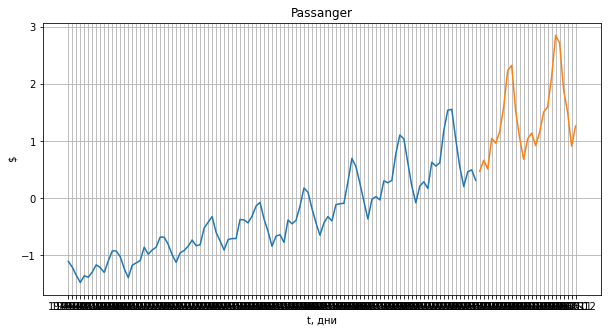

In [18]:
plt.figure(figsize = (10,5))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid()
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Passanger')
plt.show()

In [19]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length = xLen,
    sampling_rate = 1,
    batch_size = batch_size,
)

In [20]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (19, 7, 3)
Target shape: (19,)


In [21]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

Epoch 1/1000
4/4 [==============================] - 4s 276ms/step - loss: 0.6533 - mae: 0.6908 - val_loss: 2.5712 - val_mae: 1.5220
Epoch 2/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.5667 - mae: 0.6408 - val_loss: 2.3736 - val_mae: 1.4565
Epoch 3/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.5141 - mae: 0.6071 - val_loss: 2.2081 - val_mae: 1.3976
Epoch 4/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.4666 - mae: 0.5762 - val_loss: 2.0667 - val_mae: 1.3458
Epoch 5/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.4225 - mae: 0.5458 - val_loss: 1.9468 - val_mae: 1.3015
Epoch 6/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.3789 - mae: 0.5142 - val_loss: 1.8562 - val_mae: 1.2672
Epoch 7/1000
4/4 [==============================] - 0s 52ms/step - loss: 0.3344 - mae: 0.4791 - val_loss: 1.7780 - val_mae: 1.2361
Epoch 8/1000
4/4 [==============================] - 0s 52ms/step - loss: 0.2905 - 

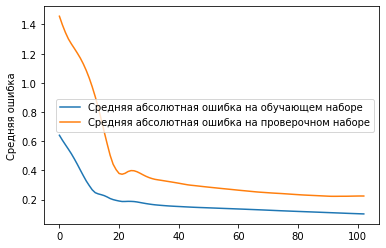

In [22]:
callbaсk = EarlyStopping(monitor='val_mae', patience=10)

model = Sequential()

model.add(LSTM(16, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(Conv1D(8, 7))

model.add(Flatten())                          
     
model.add(Dense(32, activation = "relu")) 
model.add(Dense(1, activation = "linear"))

model.compile(loss = "mse", optimizer = "adam", metrics = ['mae'])

history = model.fit(
    dataset_train,
    epochs = epochs,
    validation_data = dataset_val,
    callbacks = [callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [23]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

1/1 [==============================] - 0s 47ms/step


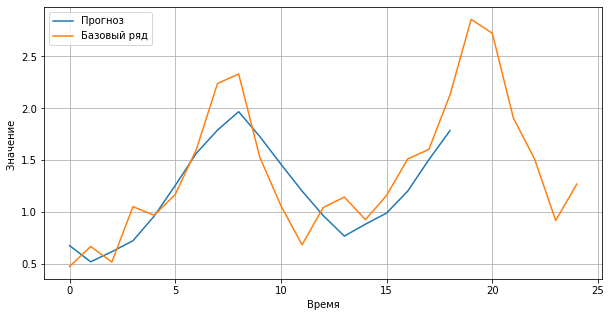

In [24]:
start = 0
step = 150
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label = 'Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

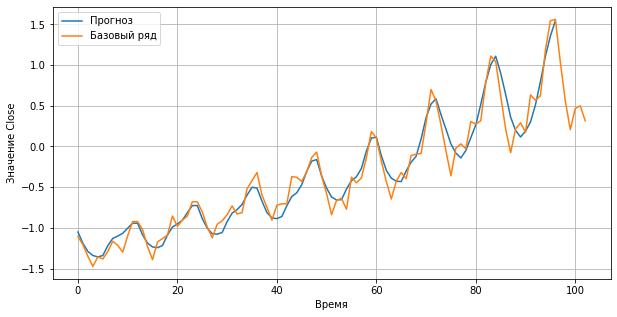

In [25]:
start = 0


plt.figure(figsize = (10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label = 'Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label = 'Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Лаговая корреляция

In [26]:
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()

    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

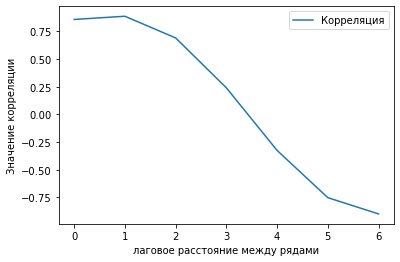

In [27]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 15 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(7):
    corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr,label = 'Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

Сеть быстро переобучается


Увеличение или добавление новых слоев сразу приводило к переобучению


Уменьшение LSTM слоя и добавление Conv1d слоя помогло увеличить качество.